# Hydro generation profile for WECC
### Bainan Xia 08/22/2019
### Refactored on 11/12/2019

In [1]:
import pandas as pd
from powersimdata.scenario.scenario import Scenario
from powersimdata.input.grid import Grid
from prereise.gather.hydrodata.eia.get_net_demand_profile_western import get_net_demand_profile_western
from prereise.gather.get_monthly_net_generation import get_monthly_net_generation
from prereise.gather.hydrodata.eia.scale_hourly_shape_profile_by_monthly_total import scale_hourly_shape_profile_by_monthly_total
from prereise.gather.hydrodata.eia.get_hourly_plant_level_hydro_profile import get_hourly_plant_level_hydro_profile
import matplotlib.pyplot as plt

In [2]:
# Create an empty dataframe of western hydro profile
s = Scenario("87")
hydro = s.state.get_hydro()
hydro_v2 = pd.DataFrame(index = hydro.index, columns = hydro.columns)

SCENARIO: base | WesternBase_2016_noHVDC_Final_2019Sep

--> State
analyze
--> Loading ct
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading hydro


# CA hydro v2

## Get hourly net demand profile based on western demand v4

In [3]:
netdemand = get_net_demand_profile_western('CA',s)

--> Loading wind
--> Loading solar
--> Loading demand
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


## Get monthly total net generation from EIA923

In [4]:
eia_923_filename = 'EIA923_Schedules_2_3_4_5_M_12_2016_Final_Revision.xlsx'
EIA_net_generation = get_monthly_net_generation('CA',eia_923_filename,'hydro')

## Scale hourly net demand profile based on EIA monthly total net genration

In [5]:
hydro_v2_state_total = scale_hourly_shape_profile_by_monthly_total(netdemand,EIA_net_generation,leap_year=True)

## Decompose total hydro profile v2 into plant level profile based on hydro generator capacities

In [6]:
hydro_v2_state = get_hourly_plant_level_hydro_profile(hydro_v2_state_total,'CA')
hydro_v2_state.index = hydro_v2.index
for plantid in hydro_v2_state.columns:
    hydro_v2[plantid] = hydro_v2_state[plantid].copy()

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


# WA hydro v2

## Get hourly profile for top 20 dams from CoreArmy database

In [7]:
filename = 'hydro_gmt.csv'
filedir = '../../data/'
aggregate_hourly_profile_wa_nw = pd.read_csv(filedir+filename,header = 0,index_col = 'DateTimeUTC')
aggregate_hourly_profile_wa_nw = list(aggregate_hourly_profile_wa_nw.dropna()['sum_hydro'])

## Get monthly total net generation from EIA923

In [8]:
EIA_net_generation = get_monthly_net_generation('WA',eia_923_filename,'hydro')

## Scale top 20 dams hourly profile based on EIA monthly total net genration

In [9]:
hydro_v2_state_total = scale_hourly_shape_profile_by_monthly_total(aggregate_hourly_profile_wa_nw,EIA_net_generation,leap_year=True)

## Decompose total hydro profile v2 into plant level profile based on hydro generator capacities

In [10]:
hydro_v2_state = get_hourly_plant_level_hydro_profile(hydro_v2_state_total,'WA')
hydro_v2_state.index = hydro_v2.index
for plantid in hydro_v2_state.columns:
    hydro_v2[plantid] = hydro_v2_state[plantid].copy()

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


# The rest of states in WECC hydro v2

In [11]:
rest_of_states = ['OR','AZ','NV','ID','MT','UT','CO','NM']
for state in rest_of_states:
    EIA_net_generation = get_monthly_net_generation(state,eia_923_filename,'hydro')
    hydro_v2_state_total = scale_hourly_shape_profile_by_monthly_total(aggregate_hourly_profile_wa_nw,EIA_net_generation,leap_year=True)
    hydro_v2_state = get_hourly_plant_level_hydro_profile(hydro_v2_state_total,state)
    hydro_v2_state.index = hydro_v2.index
    for plantid in hydro_v2_state.columns:
        hydro_v2[plantid] = hydro_v2_state[plantid].copy()

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant


## For WY, WA top 20 dams hourly profile is not suitable since it violates the maximum capacity in the peak hours. In this version, we apply a flat hourly profile based on the monthly total net generation from EIA 923 for WY in each month.

In [12]:
constant_hourly_profile = [1]*8784
EIA_net_generation = get_monthly_net_generation('WY',eia_923_filename,'hydro')
hydro_v2_state_total = scale_hourly_shape_profile_by_monthly_total(constant_hourly_profile,EIA_net_generation,leap_year=True)
hydro_v2_state = get_hourly_plant_level_hydro_profile(hydro_v2_state_total,'WY')
hydro_v2_state.index = hydro_v2.index
for plantid in hydro_v2_state.columns:
    hydro_v2[plantid] = hydro_v2_state[plantid].copy()

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


In [13]:
# Store the final hydro v2 profile as a reference, later we will roll back this profile based on TAMU hydro capacities 
# to get the final hydro profile input of the simulation.
hydro_v2.to_csv('western_hydro_v2_reference.csv')

# Sanity check

## Total net generation in each state and each month should match

In [14]:
hydro_v2.sum().sum()

174543031.141

In [15]:
EIA_net_generation = {}
filedir = '../../data/'
plant_generation = pd.read_excel(io = filedir + eia_923_filename, header = 0, usecols = 'A,D,G,I,P,CB:CM',skiprows = range(5))
for state in ['WA','OR','CA','NV','ID','CO','MT','NM','AZ','UT','WY']:
    net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == state) & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
    # Drop unnecessary columns, plant ID, etc..
    net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
    # Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
    net_generation = net_generation.replace('.',0)
    EIA_net_generation[state] = list(net_generation.apply(lambda x: x[x>0].sum()).values)
sum_chk = 0
for val in EIA_net_generation.values():
    sum_chk += sum(val)
sum_chk

174543031.14099997

## Generation factor for plants should below 1 

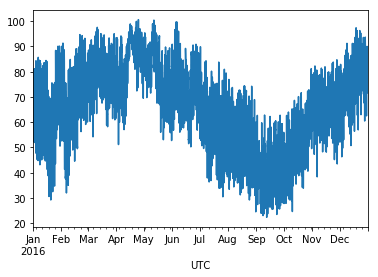

In [16]:
hydro_v2[hydro_v2.columns[0]].plot()

In [17]:
western = Grid(['Western'])
plant = western.plant
hydro_v2_factor = hydro_v2.copy()
for plantid in hydro_v2.columns:
    cap = plant.loc[plantid]['GenMWMax']
    hydro_v2_factor[plantid] = hydro_v2_factor[plantid].apply(lambda x: x/cap)

--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


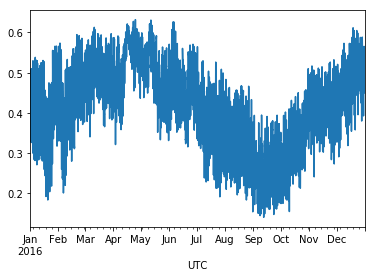

In [18]:
hydro_v2_factor[hydro_v2_factor.columns[0]].plot()

In [19]:
hydro_v2_factor.apply(lambda x: x>1).sum().sum()

10800

In [20]:
hydro_v2_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Columns: 715 entries, 10390 to 12863
dtypes: float64(715)
memory usage: 48.0 MB


## Calculate capacity factor based on 2016 western hydro capacity for each state from scenario design document rather than TAMU hydro capacities.

In [21]:
from collections import defaultdict
total_hydro_capacity = defaultdict(float)
for plantid in hydro_v2.columns:
    state = plant.loc[plantid]['zone_name']
    if state in {'Northern California','Bay Area','Central California','Southwest California','Southeast California'}:
        total_hydro_capacity['California'] += plant.loc[plantid]['GenMWMax']
    else:
        total_hydro_capacity[state] += plant.loc[plantid]['GenMWMax']
eia_cap = {
    'Arizona':2912,
    'California':13801,
    'Colorado':1178,
    'Idaho':2543,
    'Montana Western':2665,
    'Nevada':1052,
    'New Mexico Western':82,
    'Oregon':8451,
    'Utah':262,
    'Washington':21437,
    'Wyoming':303
}
scale_f = {}
for state in eia_cap:
    f = eia_cap[state]/total_hydro_capacity[state]
    if state == 'California':
        scale_f['Northern California'] = f
        scale_f['Bay Area'] = f
        scale_f['Central California'] = f
        scale_f['Southwest California'] = f
        scale_f['Southeast California'] = f
    else:
        scale_f[state] = f
scale_f

{'Arizona': 1.0082404099794096,
 'Northern California': 1.0635106094975635,
 'Bay Area': 1.0635106094975635,
 'Central California': 1.0635106094975635,
 'Southwest California': 1.0635106094975635,
 'Southeast California': 1.0635106094975635,
 'Colorado': 1.1004203614066421,
 'Idaho': 1.0930128250977846,
 'Montana Western': 1.0375274845681384,
 'Nevada': 1.0121223966017905,
 'New Mexico Western': 1.2443095281423788,
 'Oregon': 1.018155980123368,
 'Utah': 1.44114414675395,
 'Washington': 1.012717518709653,
 'Wyoming': 1.1707882537671188}

In [22]:
total_hydro_capacity

defaultdict(float,
            {'Washington': 21167.798131224,
             'Oregon': 8300.299919641006,
             'California': 12976.833401333002,
             'Nevada': 1039.3999812,
             'Arizona': 2888.2000475060004,
             'Utah': 181.79999592,
             'New Mexico Western': 65.90000168399999,
             'Colorado': 1070.50000283,
             'Wyoming': 258.79999993600006,
             'Idaho': 2326.5966707870007,
             'Montana Western': 2568.606653451})

In [23]:
hydro_v2_factor_scale = hydro_v2.copy()
cnt = 0
for plantid in hydro_v2.columns:
    cap = plant.loc[plantid]['GenMWMax']*scale_f[plant.loc[plantid]['zone_name']]
    hydro_v2_factor_scale[plantid] = hydro_v2_factor_scale[plantid].apply(lambda x: x/cap)
    for index, val in hydro_v2_factor_scale[plantid].items():
        if val > 1:
            cnt += 1
            print(cnt,index,plant.loc[plantid]['zone_name'],hydro_v2[plantid][index],cap,val)

In [24]:
hydro_v2_factor_scale.to_csv('western_hydro_v2_factor_reference.csv')

## Check the generation output percentage factor with the 2016 reference rather than the capacities in TAMU network

In [25]:
hydro_v2_factor_scale.apply(lambda x: x>1).sum().sum()

0

## Generate the final hydro v2 profile, which uses capacities in TAMU network as references. In this way, after we apply the change table function when creating the WECC basecase scenario, this hydro profile will be scaled back to the profile we generated above: western_hydro_v2_reference.csv

In [26]:
hydro_v2_tamu_cap = hydro_v2.copy()
for plantid in hydro_v2.columns:
    factor = scale_f[plant.loc[plantid]['zone_name']]
    hydro_v2_tamu_cap[plantid] = hydro_v2_tamu_cap[plantid].apply(lambda x: x/factor)

In [27]:
hydro_v2_tamu_cap.to_csv('western_hydro_v2.csv')